In [ ]:
from google.colab import drive
import torch
import matplotlib.pyplot as plt
import pandas as pd

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount("/content/drive")
raw_data_path = "/content/drive/My Drive/Colab Notebooks/Fake Real Tweets/news.csv"
destination_folder = "/content/drive/My Drive/Colab Notebooks/Fake Real Tweets"

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

Mounted at /content/drive


In [ ]:
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

In [ ]:
# Read raw data
df_raw = pd.read_csv(raw_data_path)

# Prepare columns
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=destination_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [ ]:
class LSTM(nn.Module):
  def __init__(self, dimension=128):
    super(LSTM, self).__init__()
    self.embedding = nn.Embedding(len(text_field.vocab), 300)
    self.dimension = dimension
    self.lstm = nn.LSTM(input_size=300,
                        hidden_size=dimension,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=True)
    self.drop = nn.Dropout(p=0.5)
    self.fc = nn.Linear(2*dimension,1)
  
  def forward(self, text, text_len):
        text_emb = self.embedding(text)
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out  

In [ ]:
def save_checkpoint(save_path, model, valid_loss):

  if save_path == None:
    return
  state_dict = {'model_state_dict':model.state_dict(), 'valid_loss':valid_loss}
  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
  if load_path==None:
    return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  model.load_state_dict(state_dict['model_state_dict'])
  return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
  if save_path == None:
      return
  state_dict = {'train_loss_list': train_loss_list,
                'valid_loss_list': valid_loss_list,
                'global_steps_list': global_steps_list}
  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
  if load_path==None:
      return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                      labels = labels.to(device)
                      titletext = titletext.to(device)
                      titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model,best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [8/160], Train Loss: 0.6911, Valid Loss: 0.6777
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/model.pt
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/metrics.pt
Epoch [1/10], Step [16/160], Train Loss: 0.6945, Valid Loss: 0.6617
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/model.pt
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/metrics.pt
Epoch [2/10], Step [24/160], Train Loss: 0.5781, Valid Loss: 0.6486
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/model.pt
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/metrics.pt
Epoch [2/10], Step [32/160], Train Loss: 0.5909, Valid Loss: 0.6350
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/model.pt
Model saved to ==> /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/metrics.pt
Epoch [3/10], Step [40/160], Train Loss: 

Model loaded from <== /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/metrics.pt


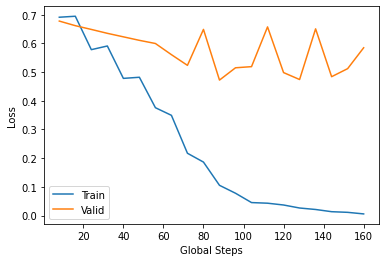

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== /content/drive/My Drive/Colab Notebooks/Fake Real Tweets/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7343    0.7539    0.7440      2816
           0     0.7506    0.7309    0.7406      2854

    accuracy                         0.7423      5670
   macro avg     0.7425    0.7424    0.7423      5670
weighted avg     0.7425    0.7423    0.7423      5670



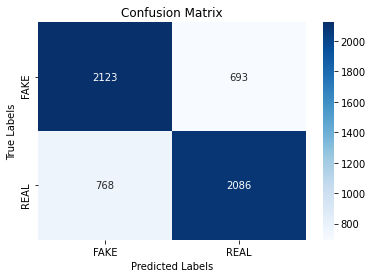

In [ ]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model)
evaluate(best_model, test_iter)